# libraries

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import optuna


# Load data


In [10]:
# Load the training and test datasets

trainD = pd.read_csv('/kaggle/input/just-ai-249-machine-learning-lab-competition/spambase_train.csv')
testD = pd.read_csv('/kaggle/input/just-ai-249-machine-learning-lab-competition/spambase_test.csv')


# Prepare data


In [11]:
# Prepare the feature matrix (X) and target vector (y) for training

Xtraining = trainD.drop(columns=['spam', 'ID'])
Ytraining = trainD['spam']

# Prepare the feature matrix for testing (without the target column)

Xtesting = testD.drop(columns=["ID"])

# Scale the feature matrices

scaler = StandardScaler()
XTrscaling = scaler.fit_transform(Xtraining)
XTescaling = scaler.transform(Xtesting)

# Data Visualization



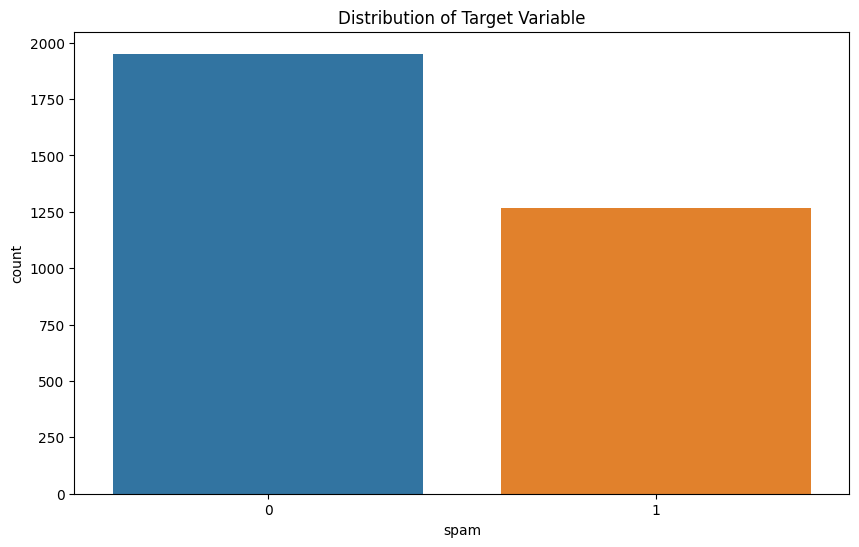

In [12]:
# Data Visualization: Plot the distribution of the target variable

plt.figure(figsize=(10, 6))
sns.countplot(x=Ytraining)
plt.title('Distribution of Target Variable')
plt.show()

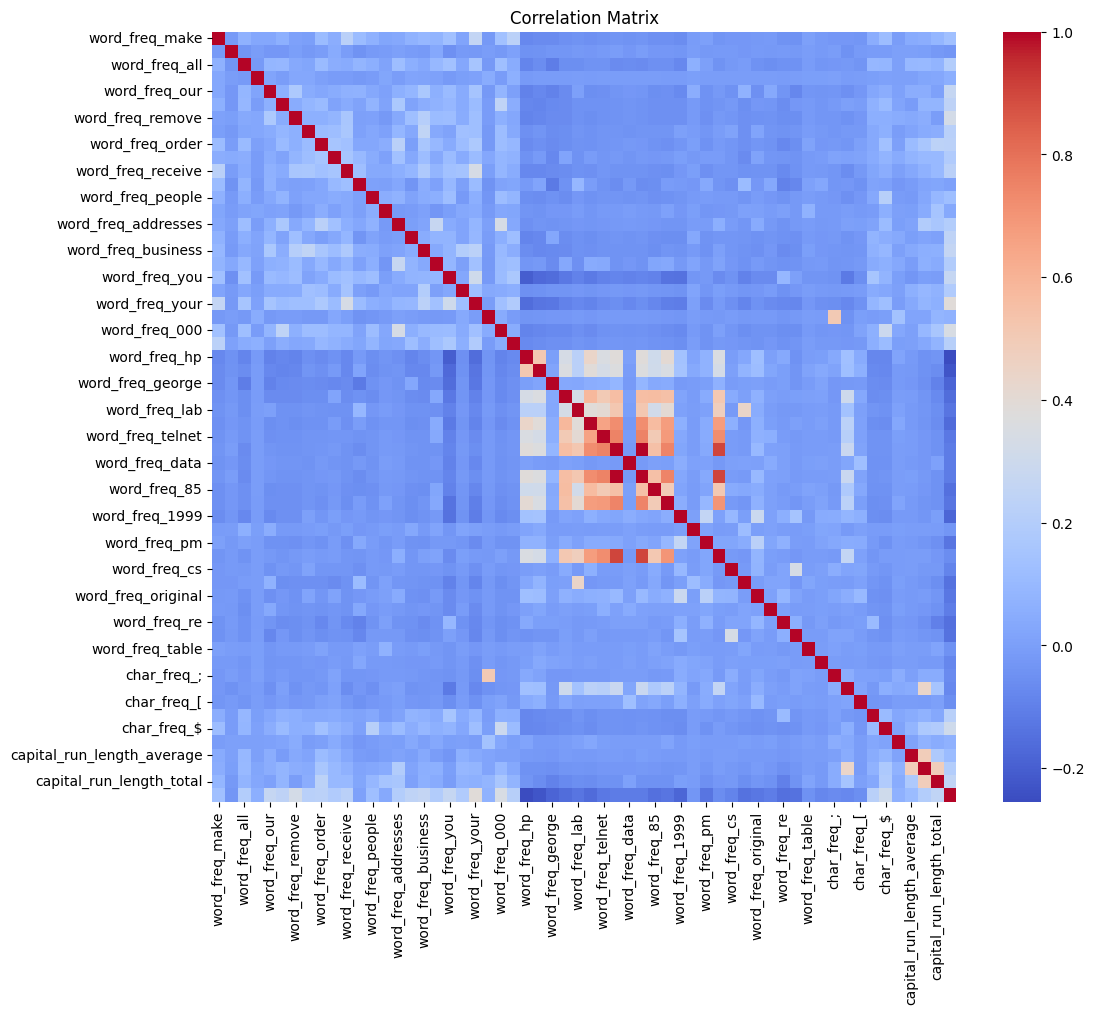

In [13]:
# Data Visualization: Plot the correlation matrix of the features

plt.figure(figsize=(12, 10))
sns.heatmap(trainD.drop(columns=['ID']).corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Objective function for Optuna


In [14]:
# Define the objective function for Optuna hyperparameter optimization

def objective(trial):
        # Define the hyperparameter search space

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Initialize and train the Random Forest model with the current hyperparameters

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(XTrscaling, Ytraining)
    
    # Make predictions on the training set
    predictions = model.predict(XTrscaling)
    
    # Calculate the F1 score

    f1 = f1_score(Ytraining, predictions)
    
    return f1

# Optuna study

In [ ]:
# Create an Optuna study to maximize the F1 score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-06-08 15:43:44,453] A new study created in memory with name: no-name-9a5cc850-0fc5-45d0-9e15-b4ccad4386e7
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2024-06-08 15:43:50,827] Trial 0 finished with value: 0.9533089727974016 and parameters: {'n_estimators': 813, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'auto', 'bootstrap': False}. Best is trial 0 with value: 0.9533089727974016.
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

In [ ]:
# Retrieve the best hyperparameters and F1 score from the study

best_params = study.best_params
best_score = study.best_value


In [ ]:
print(f"Best F1 Score: {best_score}")
print(f"Best Parameters: {best_params}")


# Visualization of Optuna optimization

In [ ]:
# Visualize the optimization history and parameter importance

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

# Train best model


In [ ]:
# Train the best model with the optimal hyperparameters
if best_params['max_features'] == 'auto':
 best_params['max_features'] = 'sqrt'
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(XTrscaling, Ytraining)
# Make predictions on the training set

train_predictions = best_model.predict(XTrscaling)


# Evaluation


In [ ]:
# Evaluate the model performance on the training set

train_accuracy = accuracy_score(Ytraining, train_predictions)
print(f'Training Accuracy: {train_accuracy}')
print(classification_report(Ytraining, train_predictions))

# Confusion Matrix


In [ ]:
# Plot the confusion matrix

cm = confusion_matrix(Ytraining, train_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Feature Importance

In [ ]:
# Plot feature importance

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = Xtraining.columns
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(Xtraining.shape[1]), importances[indices], align="center")
plt.xticks(range(Xtraining.shape[1]), features[indices], rotation=90)
plt.show()

# Predict on test set

In [ ]:
# Make predictions on the test set

test_predictions = best_model.predict(XTescaling)


# submission

In [ ]:
# Create a submission DataFrame

submission_df = pd.DataFrame({
    'ID': testD['ID'],
    'spam': test_predictions
})

# Save the submission to a CSV file

submission_df.to_csv('lulu1.csv', index=False)